In [2]:
!pip install -q accelerate
!pip install -q scikit-learn
!pip install -q tqdm
!pip install torchinfo 
!pip install -q pandas
!pip install -q matplotlib 
!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
file_id = '1w3IQMK3PmXH-Bq6Lt_P8wxGPvr5olrZT'
destination = 'pfam.zip'
n_families_of_interest = 1000
data_dirpath = "pfam"
os.makedirs("models", exist_ok=True)
vocab_size = 32
max_aminoacid_len = 512
batch_size = 128
pin_memory_flag = True

mixed_precision = "fp16" # or "fp32"

In [4]:
import os
import gc
import json
import zipfile
import requests
import numpy as np
import pandas as pd
from functools import partial 
from tqdm.notebook import tqdm 
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
from accelerate import Accelerator
from torchinfo import summary
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef

2023-04-24 00:34:53.131192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def format_size(value):
  if value >= 1024**3:
    return f"{round(value / 1024**3 , 3)} GB"
  elif value >= 1024**2:
    return f"{round(value / 1024**2 , 3)} MB"
  elif value >= 1024:
    return f"{round(value / 1024 , 3)} KB"
  return f"{value} B"

# Code taken from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    params = { 'id' : id, 'confirm' : 1 }
    response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    pb = tqdm(response.iter_content(CHUNK_SIZE))
    b_total = 0
    with open(destination, "wb") as f:
        for i,chunk in enumerate(pb):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                b_total += len(chunk)

                if i % 1000 == 0:
                  pb.set_description(f"written : {format_size(b_total)}")
                i += 1
    print("\n")
    print(f"saved all the data to {destination}. total size : {format_size(os.stat(destination).st_size)}")

In [6]:
download_file_from_google_drive(file_id, destination)
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(".")
!mv random_split pfam

0it [00:00, ?it/s]



saved all the data to pfam.zip. total size : 493.095 MB
mv: cannot move 'random_split' to 'pfam/random_split': Directory not empty


In [7]:
data_dirpath = "pfam"
print('Available dataset partitions: ', os.listdir(data_dirpath))

Available dataset partitions:  ['dev', 'train', 'test', 'random_split']


In [8]:
def read_all_shards(partition='dev', data_dir = data_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    
    return pd.concat(shards)

def read_all_data_initial():
  global train, test, dev, all_train_ds_size, all_test_ds_size, all_dev_ds_size

  test = read_all_shards('test')
  dev = read_all_shards('dev')
  train = read_all_shards('train')

  partitions = {'test': test, 'dev': dev, 'train': train}
  for name, df in partitions.items():
      print('Dataset partition "%s" has %d sequences' % (name, len(df)))

  all_train_ds_size = len(train)
  all_test_ds_size = len(test)
  all_dev_ds_size = len(dev)

  train.reset_index(inplace=True, drop=True)
  dev.reset_index(inplace=True, drop=True)
  test.reset_index(inplace=True, drop=True)

read_all_data_initial()

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


how many labels : 17929


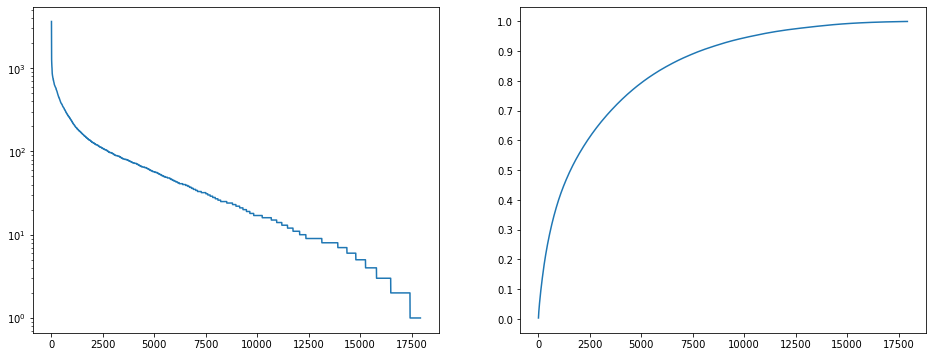

In [9]:
def plot_counts(data):

    counter = Counter(data['family_accession'])
    print(f"how many labels : {len(counter)}")
    
    datasetSize = len(data)
    xs = []
    x_labels = []
    ys = []

    t = 0
    cumulative = []

    for i,(x, y) in  enumerate(counter.most_common()):
        xs.append(i)
        x_labels.append(x)
        ys.append(y)
        t += y / datasetSize
        cumulative.append(t)

    plt.figure(figsize=(16 ,6))
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(xs, cumulative)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    plt.show()
    return cumulative

cumulative = plot_counts(train)

In [10]:
print(f"{n_families_of_interest} classes is {100 * round( cumulative[n_families_of_interest-1],3)} portion of training data")

1000 classes is 40.400000000000006 portion of training data


how many labels : 991


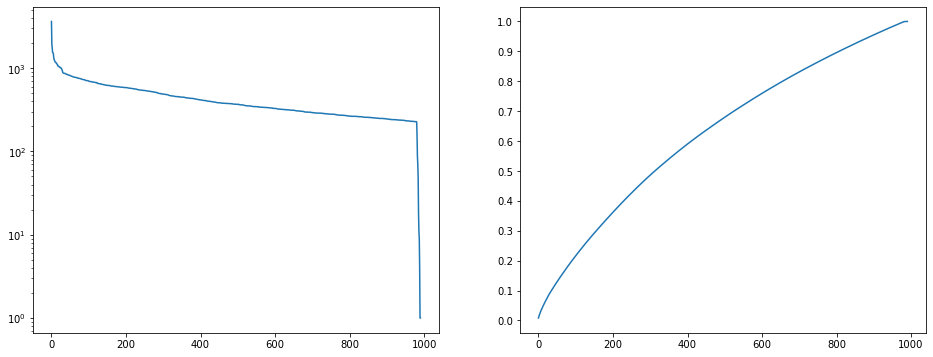

In [11]:
familiesOfInterest = train.family_accession.value_counts()[:n_families_of_interest]

mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]
mask = train["sequence"].str.len() <= max_aminoacid_len
train = train.loc[mask, :]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]
mask = dev["sequence"].str.len() <= max_aminoacid_len
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]
mask = test["sequence"].str.len() <= max_aminoacid_len
test = test.loc[mask,:]

cumulative_split = plot_counts(train)

In [12]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']
train_sentences = train_seq.apply(lambda seq: " ".join([aa for aa in seq]))
validation_sentences = dev_seq.apply(lambda seq: " ".join([aa for aa in seq]))
test_sentences = test_seq.apply(lambda seq: " ".join([aa for aa in seq]))

train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

In [13]:
class Tokenizer(object):
    def __init__(self, vocab_size, padding=512):
        self.idx_to_token = {0: '<pad>', 1:'<s>', 2:'</s>', 3: '<unk>'}
        self.token_to_idx = {k:j for j,k in self.idx_to_token.items()} 
        self.max_size = vocab_size
        self.padding = padding + 2
    
    def __len__(self):
        return len(self.token_to_idx)

    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]
    
    def build_vocabulary(self, sentences):
        idx = 4
        frequencies = {}
   
        for sentence in tqdm(sentences):
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1
                    
        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items()} 
        
        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
            
        #create vocab
        for word in frequencies.keys():
            self.token_to_idx[word] = idx
            self.idx_to_token[idx] = word
            idx+=1
            
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = [self.token_to_idx["<s>"]]
        for token in tokenized_text:
            if token in self.token_to_idx.keys():
                numericalized_text.append(self.token_to_idx[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.token_to_idx['<unk>'])
        
        numericalized_text.append(self.token_to_idx['</s>'])
        if self.padding != -1:
          numericalized_text = numericalized_text + [self.token_to_idx["<pad>"]] * (self.padding - len(numericalized_text))

        return np.array(numericalized_text)

tokenizer = Tokenizer(vocab_size)
tokenizer.build_vocabulary(train_sentences)
train_sentences = train_sentences.apply(tokenizer.numericalize)
validation_sentences = validation_sentences.apply(tokenizer.numericalize)
test_sentences = test_sentences.apply(tokenizer.numericalize)
train_sentences = train_sentences.values
validation_sentences = validation_sentences.values
test_sentences = test_sentences.values
print(Counter([len(v) for v in train_sentences]))
print(Counter([len(v) for v in validation_sentences]))
print(Counter([len(v) for v in test_sentences]))
keys = Counter(train_labels.values).keys()
family_id_to_val = {k : v for v, k in enumerate(keys)}

train_labels = train_labels.map(family_id_to_val).values
validation_labels = validation_labels.map(family_id_to_val).values
test_labels = test_labels.map(family_id_to_val).values

  0%|          | 0/432209 [00:00<?, ?it/s]

Counter({514: 432209})
Counter({514: 53471})
Counter({514: 53465})


In [15]:
class Aminoacid_dataset_train(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(train_sentences)

    def __getitem__(self, index):
        return torch.tensor(train_sentences[index]), torch.tensor(train_labels[index]) 

class Aminoacid_dataset_val(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(validation_sentences)

    def __getitem__(self, index):
        return torch.tensor(validation_sentences[index]), torch.tensor(validation_labels[index]) 

class Aminoacid_dataset_test(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(test_sentences)

    def __getitem__(self, index):
        return torch.tensor(test_sentences[index]), torch.tensor(test_labels[index]) 

train_dataset = Aminoacid_dataset_train()
val_dataset = Aminoacid_dataset_val()
test_dataset = Aminoacid_dataset_test()

# for final evaluation
test_dl = DataLoader(test_dataset, batch_size=batch_size, 
                      pin_memory=True, shuffle=False)

In [16]:
def evaluate_model(model, dataset, metrics=[], report_every=100):
  pb = tqdm(dataset)
  model.eval()
  classified_correctly = 0
  len_so_far = 0
  loss_whole = 0
  preds = torch.zeros(len(dataset.dataset))
  true_preds = torch.zeros(len(dataset.dataset))

  for i, (source, targets) in enumerate(pb):
    source = source.to(device)
    targets = targets.to(device)
    output = model(source)
    loss = F.cross_entropy(output, targets)
    pred = torch.argmax(output, dim=1)

    classified_correctly += torch.sum(pred == targets).item()

    # save the predictions for later evalution 
    preds[len_so_far:(len_so_far+targets.shape[0])] = pred
    true_preds[len_so_far:(len_so_far+targets.shape[0])] = targets

    len_so_far += targets.shape[0]
    loss_whole += targets.shape[0] * loss.item()

    if i % report_every == 0:
      pb.set_description(f"Loss : {round(loss.item(), 3)}, Accuracy : {round(classified_correctly / len_so_far, 4)}")

  evaluations = {}
  for metric in metrics:
    if isinstance(metric, partial):
      evaluations[metric.func.__name__] = metric(preds, true_preds)  
    else:
      evaluations[metric.__name__] = metric(preds, true_preds)  
  evaluations["loss"] = loss_whole / len_so_far


In [17]:
accelerator = Accelerator(mixed_precision=mixed_precision)
device = accelerator.device

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dil, filters, ks=3):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels, filters, ks, padding="same", dilation=dil)
        
        self.bn2 = nn.BatchNorm1d(filters)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv1d(filters, filters, ks, padding="same")
        
    def forward(self, x):
        shortcut = x
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        
        x += shortcut
        return x


class ProtCNN(nn.Module):
    def __init__(self, numclass, inp_size, vocab_size, residuals_ks=3, residuals_filters=64):
        super(ProtCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size, padding_idx=None)
        self.embedding.weight.data.copy_(torch.eye(vocab_size))
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv1d(inp_size, 64, 8, padding="same")
        
        self.res_block1 = ResidualBlock(64, 1, residuals_filters, ks=residuals_ks)
        self.res_block2 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks)
        
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        
        self.res_block3 = ResidualBlock(64, 1, residuals_filters, ks=residuals_ks)
        self.res_block4 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks)
        
        self.conv3 = nn.Conv2d(1, 32, (4, 4), padding="same")
        self.conv4 = nn.Conv2d(32, 8, (8, 8), padding="same")
        self.maxpool = nn.MaxPool2d((64, 64))
        self.fc = nn.Linear(8, numclass+1)

    def forward(self, x):
        x = self.embedding(x)
        # x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = x.unsqueeze(1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = F.softmax(x, dim=1)
        return x

In [24]:
model_name = os.path.join("models","protCNN1_ks=5.pt")
evaluate_model(torch.load(model_name), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

  0%|          | 0/418 [00:00<?, ?it/s]

In [35]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dil, filters, ks=3):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels, filters, ks, padding="same", dilation=dil)
        
        self.bn2 = nn.BatchNorm1d(filters)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv1d(filters, filters, ks, padding="same")
        
    def forward(self, x):
        shortcut = x
        #print(x.shape)
        x = self.bn1(x)
        #print(x.shape)
        x = self.relu1(x)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        
        x = self.bn2(x)
        #print(x.shape)
        x = self.relu2(x)
        #print(x.shape)
        x = self.conv2(x)
        
        #print(x.shape, shortcut.shape)
        x += shortcut
        return x


class ProtCNN2(nn.Module):
    def __init__(self, numclass, inp_size, vocab_size, residuals_ks1=3, residuals_ks2=3, residuals_filters=64):
        super(ProtCNN2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size, padding_idx=None)
        self.embedding.weight.data.copy_(torch.eye(vocab_size))
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv1d(inp_size, residuals_filters, 8, padding="same")
        
        self.res_block1 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks1)
        self.res_block2 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks1)
        self.res_block3 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks1)
        
        self.conv2 = nn.Conv1d(32, residuals_filters, 3, padding=1)
        
        self.res_block4 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks2)
        self.res_block5 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks2)
        self.res_block6 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks2)
        
        self.conv3 = nn.Conv2d(1, 32, (4, 4), padding="same")
        self.conv4 = nn.Conv2d(32, 8, (8, 8), padding="same")
        self.maxpool = nn.MaxPool2d((residuals_filters, residuals_filters))
        self.fc = nn.Linear(8, numclass+1)

    def forward(self, x):
        x = self.embedding(x)
        # x = x.permute(0, 2, 1)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.res_block1(x)
        #print(x.shape)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.res_block6(x)
        x = x.unsqueeze(1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.maxpool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = F.softmax(x, dim=1)
        return x

In [44]:
accelerator = Accelerator(mixed_precision=mixed_precision)
device = accelerator.device

In [46]:
model = ProtCNN2(n_families_of_interest, max_aminoacid_len + 2, 32, residuals_ks1=5, residuals_ks2=5, residuals_filters=128)
model = model.to("cpu")

In [48]:
model(next(iter(test_dl))[0])

tensor([[-0.2689, -0.2962,  0.0626,  ..., -0.2572,  0.0936, -0.1762],
        [-0.2241, -0.3776,  0.0010,  ..., -0.2559,  0.1331, -0.1743],
        [-0.2324, -0.3277,  0.0204,  ..., -0.1941,  0.0483, -0.1269],
        ...,
        [-0.2910, -0.2538,  0.0573,  ..., -0.2772,  0.0651, -0.2167],
        [-0.2288, -0.3191, -0.0101,  ..., -0.2280,  0.0686, -0.1395],
        [-0.2740, -0.2964,  0.0666,  ..., -0.2628,  0.0478, -0.1663]],
       grad_fn=<AddmmBackward0>)

In [49]:
model.load_state_dict(torch.load(os.path.join("models", "state_dict_ProtCNN2_ks=5_3residuals.pt")))

<All keys matched successfully>

In [51]:
model(next(iter(test_dl))[0])

: 

: 

In [ ]:
evaluate_model(model, test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

  0%|          | 0/418 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 3.82 GiB total capacity; 1.74 GiB already allocated; 288.94 MiB free; 1.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF